# PyTorch classification

Import useful packages:

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Import source code
import sys
sys.path.insert(0, '../src')

from Task_3.neural_network_v2 import NeuralNetworkV2

In [31]:
from Task_3.dnn_vanilla import VanillaDNN

## Data

Source: https://www.kaggle.com/datasets/sjleshrac/airlines-customer-satisfaction

The dataset consists of the details of customers of an airline company. The feedback of the customers is recorded as a satisfaction value: satisfied or dissatisfied. The main purpose of this dataset is to predict whether a future customer would be satisfied with their service given the details of the other parameters values. 

### Features analysis

Import dataset:

In [3]:
path = "../data/"
file_name = "Invistico_Airline.csv"

# read csv file
airline = pd.read_csv(path+file_name)

# Size of the dataset
print("Size of the dataset: {}".format(airline.shape))

Size of the dataset: (129880, 23)


The dataset consists of **22 features** (+ **1 target**), with a total of **129880 entries**.

In [4]:
airline.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


### Data analysis

It is convenient to view the features that compose the dataset in more detail:

In [5]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

The first thing that can be noticed is the presence of null values for the feature "Arrival Delay in Minutes":

In [6]:
print("'Arrival Delay in Minutes' null values: {}".format(airline["Arrival Delay in Minutes"].isnull().sum()))

'Arrival Delay in Minutes' null values: 393


Visualising the distribution of this feature:

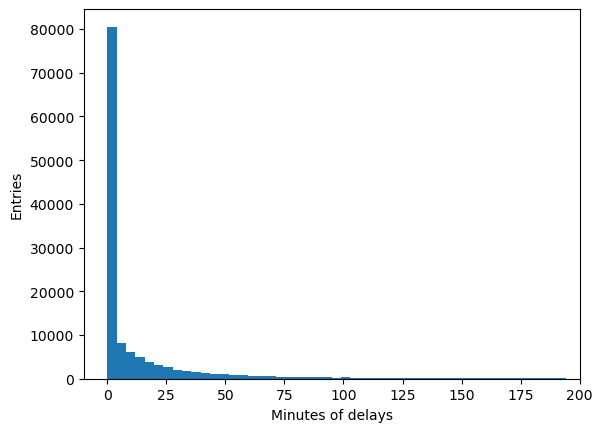

In [7]:
fig, ax = plt.subplots()

plt.hist(airline["Arrival Delay in Minutes"],bins=400);
plt.xlabel("Minutes of delays")
plt.ylabel("Entries")
ax.set_xlim(-10,200);

From the distribution, it is possible to visualise a peak value of delay minutes very close to 0. Furthermore, null values make up a small percentage of the total values: 

$393/129880\; = \;\approx 0.3 \%$

For these reasons, it was decided simply to replace the null values with 0. This is not expected to cause any particular problems in the subsequent analysis.

In [8]:
airline = airline.fillna(0)
print("'Arrival Delay in Minutes' null values: {}".format(airline["Arrival Delay in Minutes"].isnull().sum()))

'Arrival Delay in Minutes' null values: 0


### Target analysis

As far as the target of the dataset is concerned, it is convenient to assess the size of the classes, so as to prevent possible problems from an unbalanced dataset:

Target values:
satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64


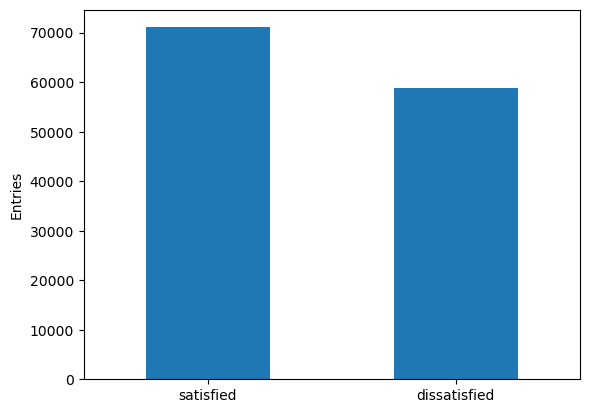

In [9]:
print("Target values:")
print(airline.satisfaction.value_counts())
airline.satisfaction.value_counts().plot(kind='bar')
plt.ylabel('Entries')
plt.xticks(rotation=0);

From the distribution of the target, there is a slight imbalance in the count, but it does not seem to be problematic. For this reason, it was decided not to apply resolution techniques for this issue, postponing a more accurate evaluation to a later stage.

### Encoding categorical features

In [10]:
encoder = LabelEncoder()

# Categorial features of the dataset
cat_features = ["satisfaction", "Gender", "Customer Type", "Type of Travel", "Class"]

# Apply label encoder to categorial features
for feat in cat_features:
    airline[feat] = encoder.fit_transform(airline[feat])

### Define dataset

In [11]:
# Define features and target sets
y = airline.satisfaction
X = airline.drop("satisfaction",axis = 1)

### Standard scaler

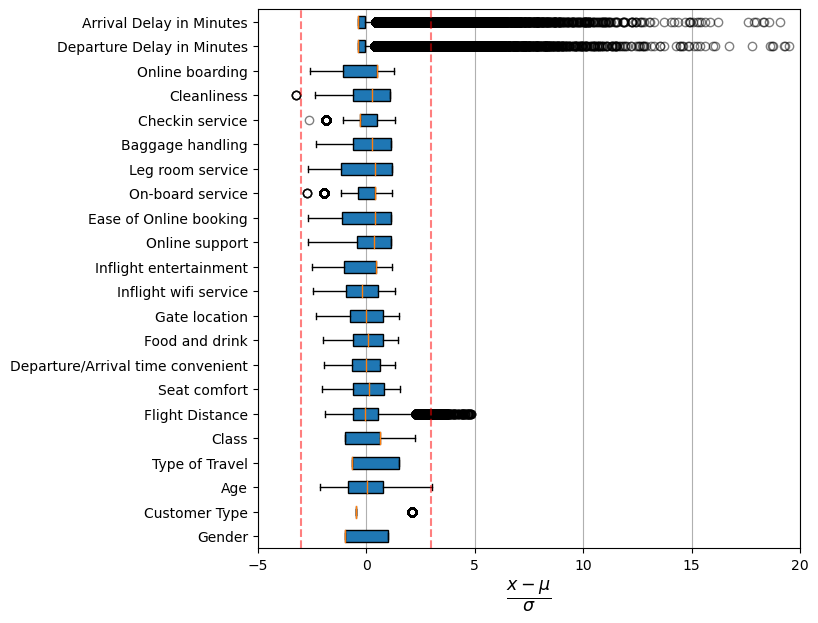

In [12]:
# Apply standard scalar transformation
st = StandardScaler()
Xst = st.fit_transform(X)

fig, ax = plt.subplots(figsize=(7,7))

bp = plt.boxplot(Xst,labels=X.columns,vert=0,patch_artist = True)
ax.axvline(3, c = "red", linestyle="--", alpha = 0.5)
ax.axvline(-3, c = "red", linestyle="--", alpha = 0.5)
ax.set_xlim(-5,20)
plt.xlabel(r'$\frac{x-\mu}{\sigma}$', fontsize=18)
plt.gca().xaxis.grid(True)

# source for aestetic improvements: https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
for dot in bp['fliers']:
    dot.set(marker ='o',
              color ='lightgrey',
              alpha = 0.5)
# plt.savefig(result_path+"/outliers")    

Remove outliers:

In [13]:
# Variable threshold to avoid too aggressive cleaning
threshold = 5

# Select indices to keep
indices = (Xst < threshold).all(axis=1)

# Remove outliers
Xst = Xst[indices]
y = y[indices].values

### Initialise PyTorch variables

In [14]:
# Split in train and test dataset
X_train, X_test, y_train, y_test = train_test_split(Xst, y, random_state=23, train_size=0.8)

In [15]:
## TEST DECISION TREE ##
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.937279391800163


In [28]:
# Create tensor
X_train_tensor = torch.tensor(X_train,dtype=torch.long)
X_test_tensor = torch.tensor(X_test,dtype=torch.long)
y_train_tensor = torch.tensor(y_train,dtype=torch.long)#, dtype=torch.long)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)#, dtype=torch.long)

# Create TensorDatasets
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_tensor, batch_size=2000, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=2000, shuffle=True)

## Neural network

In [29]:
#
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [32]:
VanillaDNN = VanillaDNN().to(device)

In [33]:
# Initialise the CNN
NN = NeuralNetwork(VanillaDNN)
NN.initialise(loss_function = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam(VanillaDNN.parameters(),lr= 0.001) )
# Fit and validate the CNN
NN.fit(train_loader, test_loader, max_epochs = 50)
# Evaluate the CNN
y_pred, y_test = NN.evaluate(test_loader,plot_flag = True)

RuntimeError: mat1 and mat2 must have the same dtype